In [1]:
import torch
%matplotlib inline
import numpy as np
import dac
from dac.attribute import get_attribution
from dac.utils import open_image
from dac.mask import get_mask
from matplotlib import pyplot as plt

In [2]:
images = "/home/hhealey/nereus/Side_Projects/ML_stickleback_populations/Oregon_ML_images_aspng/"

pop_classes = ['Chub_site', 'Columbia_River_Mouth', 'Cushman_Slough', 'Green_Island', 'Riverbend']

def class_dir(name):
    return f'{pop_classes.index(name)}_{name}'

class_A = 'Cushman_Slough'
class_B = 'Green_Island'

import cycle_gan


In [3]:
import glob
import json

result_dir = f'training_data/cycle_gan/{class_A}_{class_B}/results/test_latest/images/'
classification_results = []
for f in glob.glob(result_dir + '/*.json'):
    result = json.load(open(f))
    #print(result)
    result['basename'] = f.replace('_aux.json', '')
    classification_results.append(result)
classification_results.sort(
    key=lambda c: c['aux_real'][pop_classes.index(class_A)] * c['aux_fake'][pop_classes.index(class_B)],
    reverse=True)


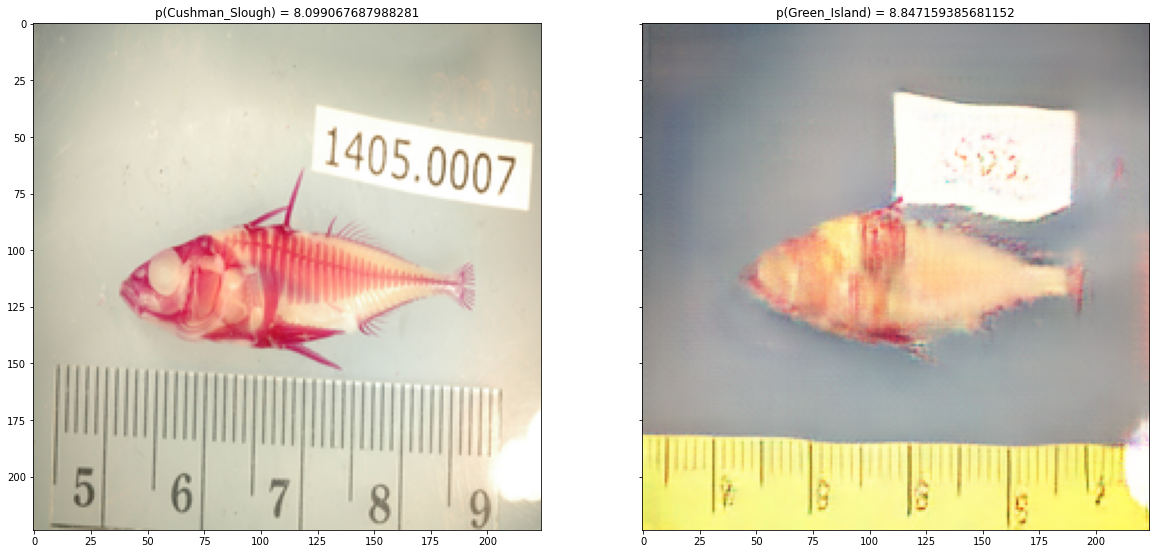

8.847159385681152 3


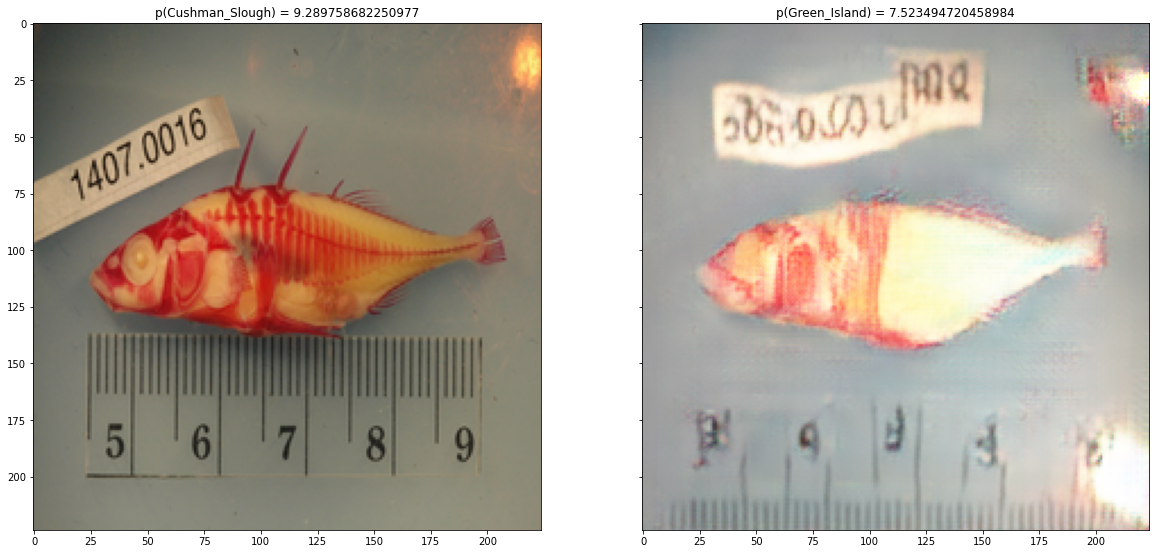

7.523494720458984 3


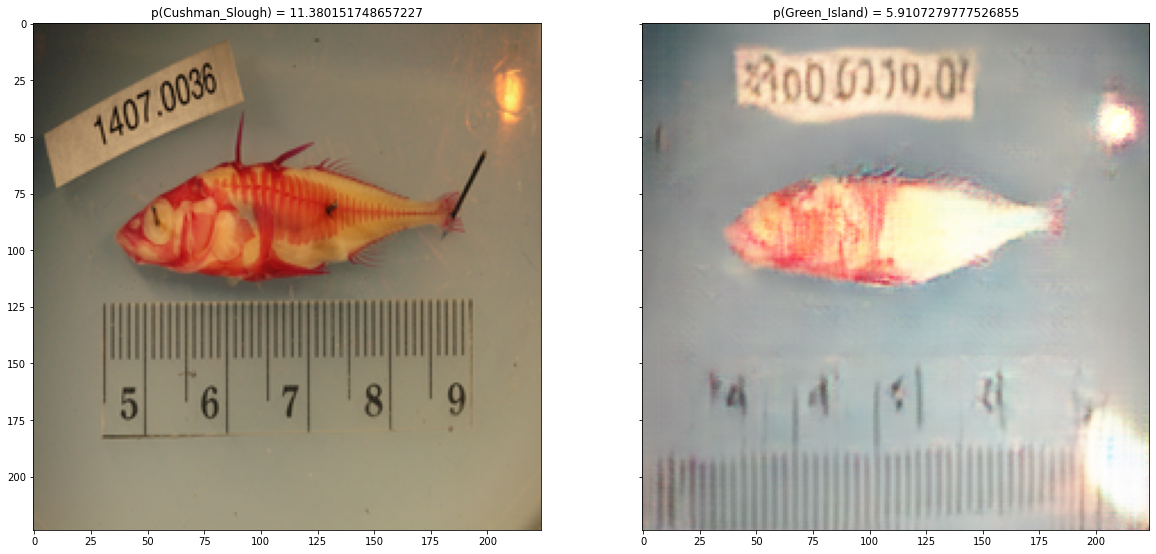

5.9107279777526855 3


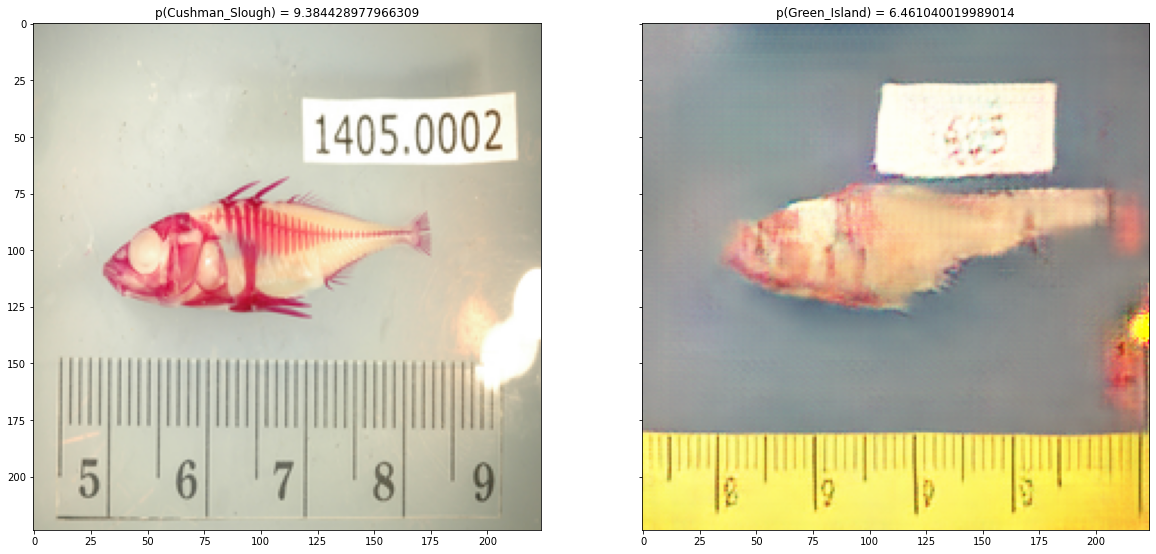

6.461040019989014 3


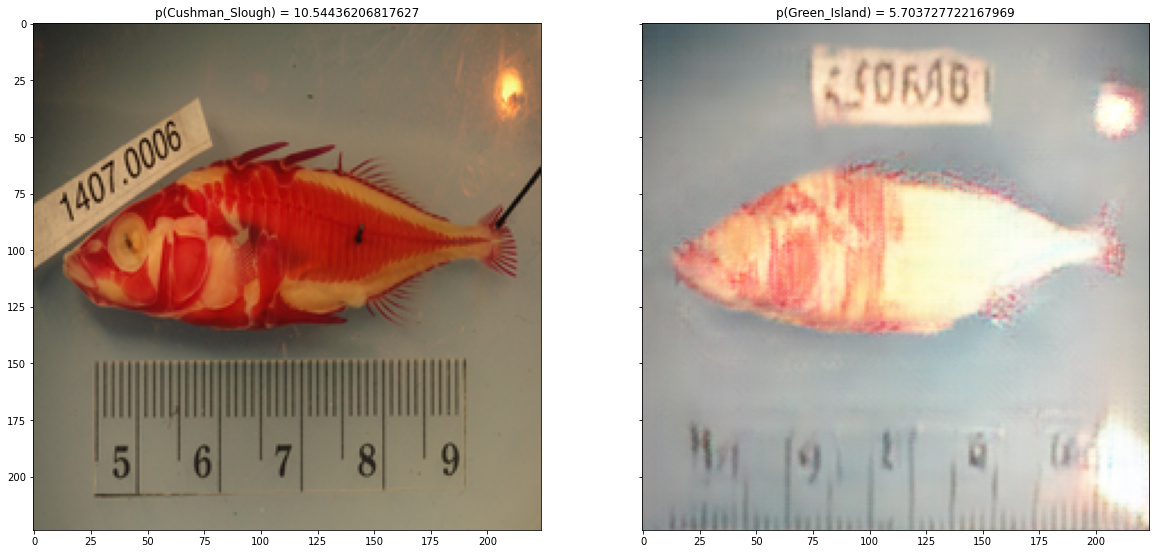

5.703727722167969 3


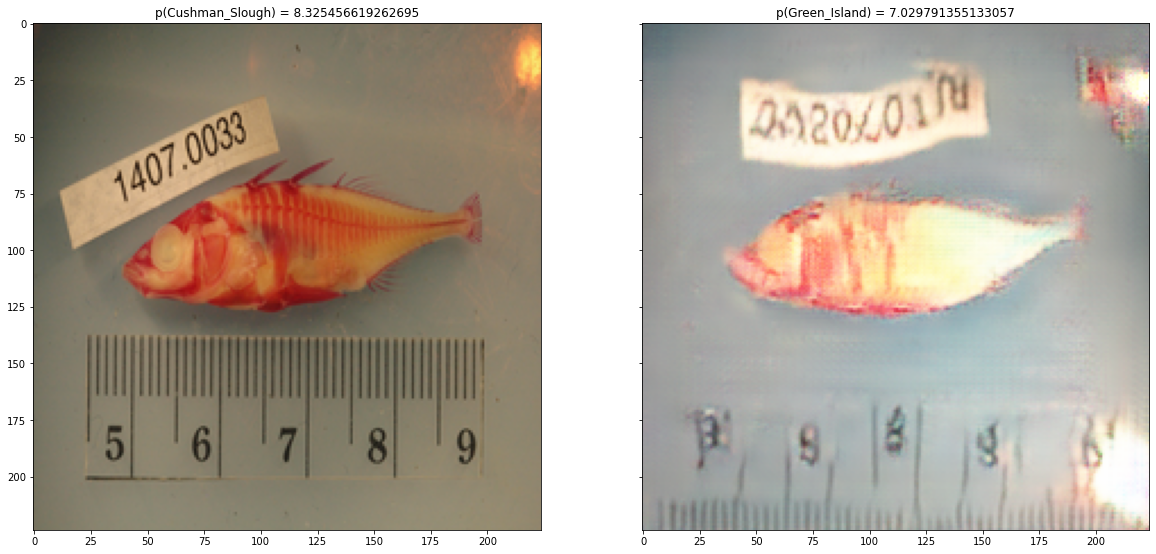

7.029791355133057 3


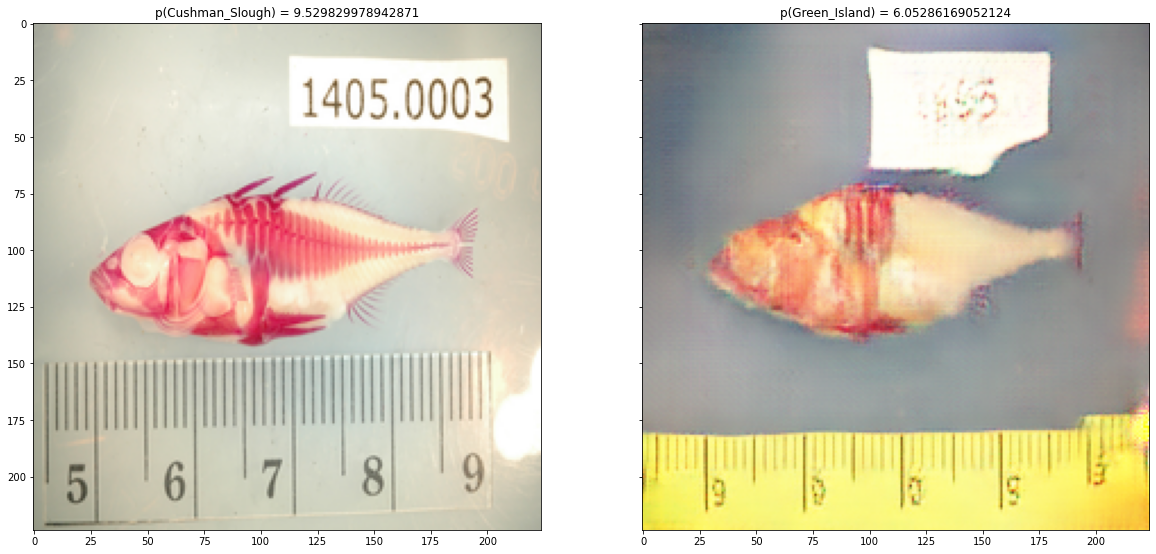

6.05286169052124 3


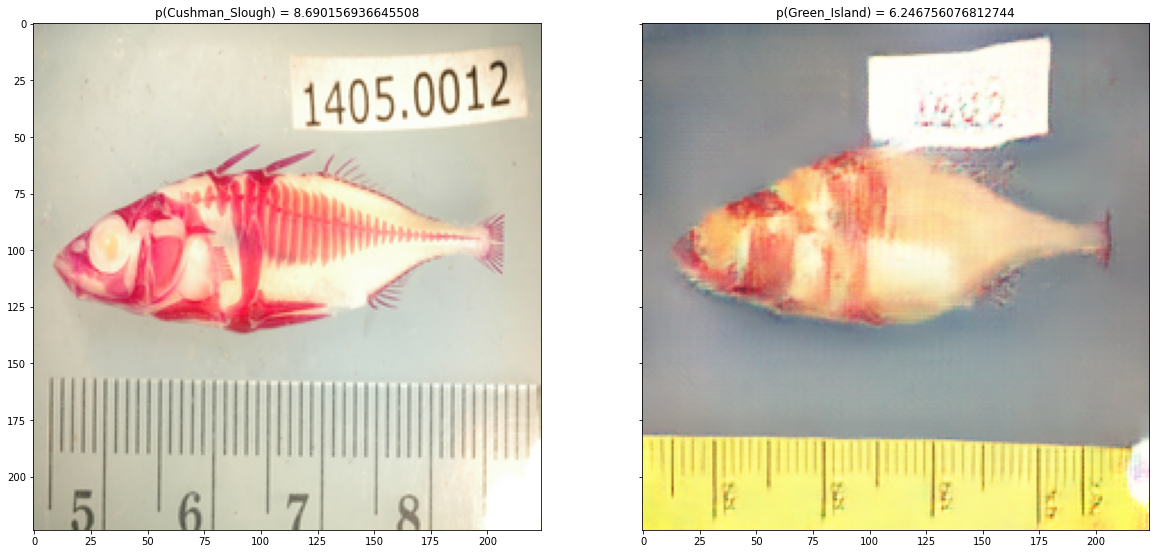

6.246756076812744 3


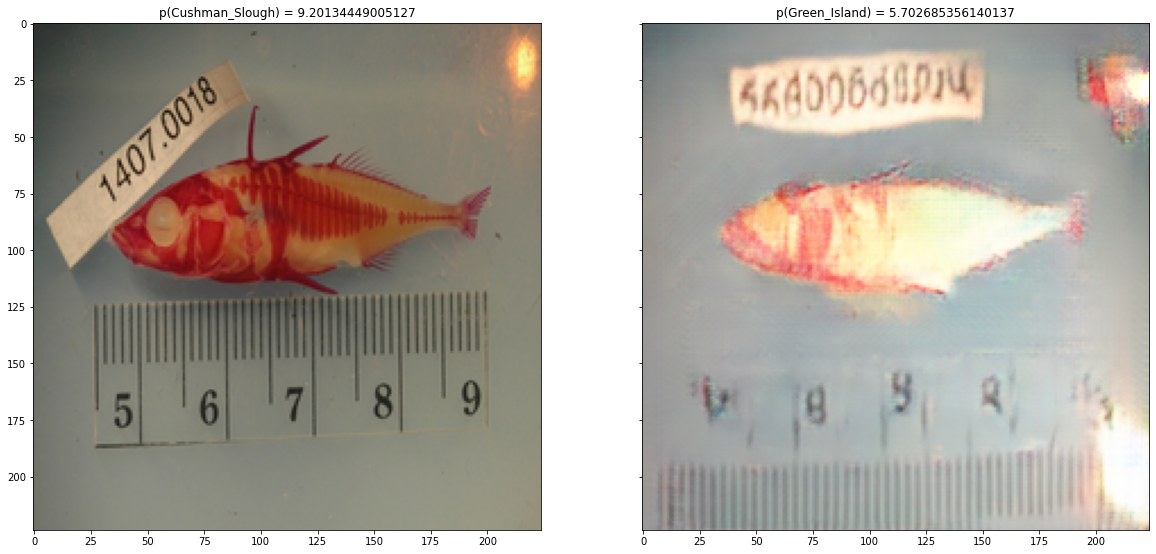

5.702685356140137 3


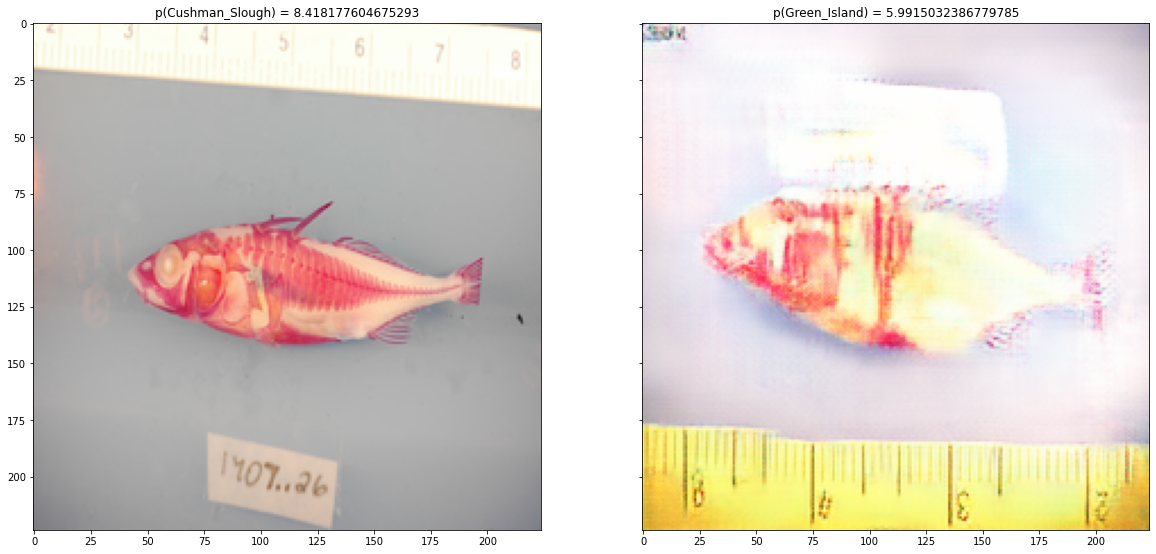

5.9915032386779785 3


In [4]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
from skimage.io import imread

def show_pair(a, b, score_a, score_b, class_a, class_b):
    fig, axs = plt.subplots(1, 2, figsize=(20, 20), sharey=True)
    axs[0].imshow(a, cmap='gray')
    axs[0].set_title(f"p({class_a}) = " + str(score_a))
    axs[1].imshow(b, cmap='gray')
    axs[1].set_title(f"p({class_b}) = " + str(score_b))
    plt.show()

# show the top successful translations (according to our VGG classifier)
for i in range(10):
    basename = classification_results[i]['basename']
    score_A = classification_results[i]['aux_real'][pop_classes.index(class_A)]
    score_B = classification_results[i]['aux_fake'][pop_classes.index(class_B)]
    score_highest = max(classification_results[i]['aux_fake'])
    score_index =  classification_results[i]['aux_fake'].index(score_highest)


    real_A = imread(basename + '_real.png')
    fake_B = imread(basename + '_fake.png')
    show_pair(real_A, fake_B, score_A, score_B, class_A, class_B)
    print(score_highest, score_index)
    
##index 3 is equal to green island (2 is equal to cushman)

training_data/cycle_gan/Cushman_Slough_Green_Island/results/test_latest/images/1405.07


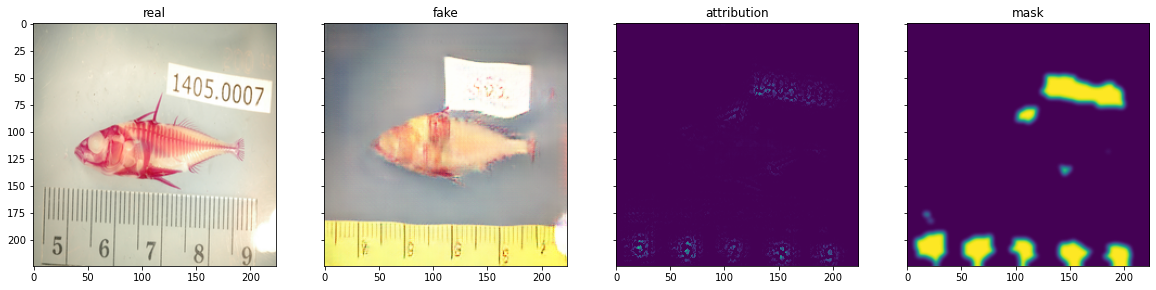

training_data/cycle_gan/Cushman_Slough_Green_Island/results/test_latest/images/1407.16


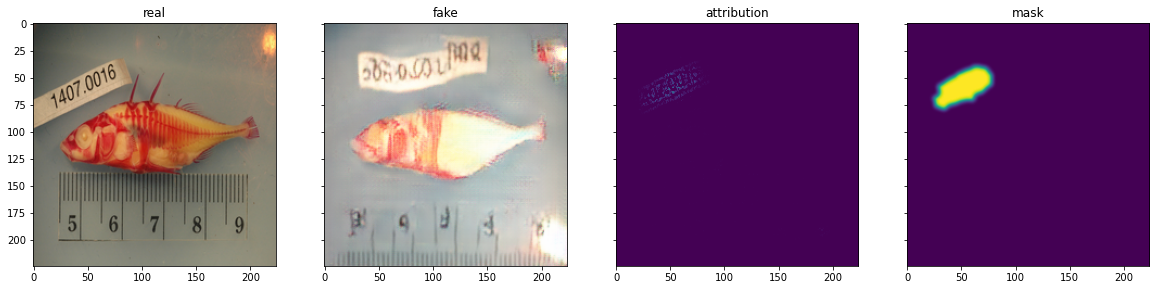

training_data/cycle_gan/Cushman_Slough_Green_Island/results/test_latest/images/1407.36


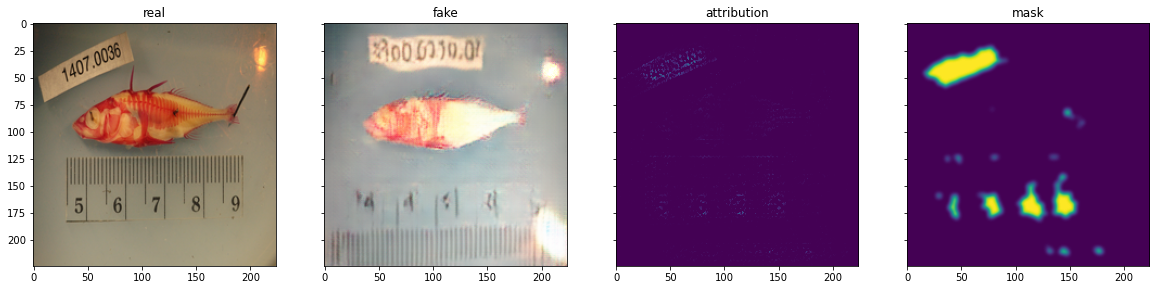

training_data/cycle_gan/Cushman_Slough_Green_Island/results/test_latest/images/1405.02


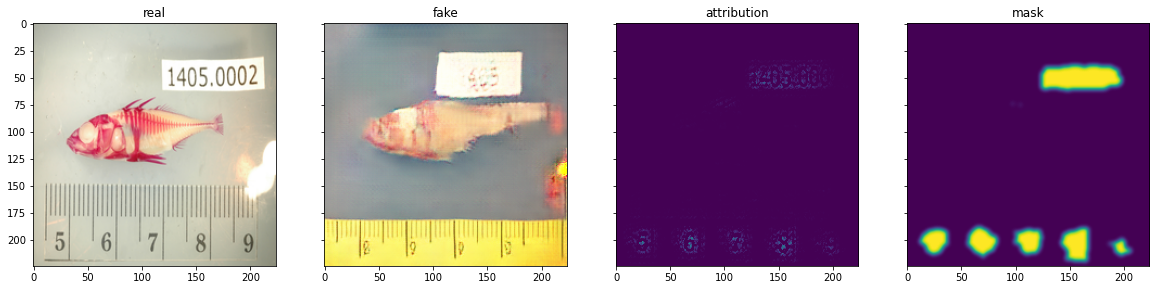

In [6]:
%matplotlib inline
import numpy as np
import dac
from dac.attribute import get_attribution
from dac.utils import open_image
from dac.mask import get_mask
from matplotlib import pyplot as plt

method = 'ggc'
mask_thres_lo = 105
mask_thres_hi = 110

downsample_factors = [(2, 2), (2, 2), (2, 2), (2, 2)]

def show_mask(real, fake, attribution, mask):
    fig, axs = plt.subplots(1, 4, figsize=(20, 20), sharey=True)
    axs[0].imshow(real, cmap='gray')
    axs[0].set_title("real")
    axs[1].imshow(fake, cmap='gray')
    axs[1].set_title("fake")
    axs[2].imshow(attribution, vmin=0.0, vmax=1.0)
    axs[2].set_title("attribution")
    axs[3].imshow(mask, vmin=0.0, vmax=1.0)
    axs[3].set_title("mask")
    plt.show()

for i in range(4):
    
    basename = classification_results[i]['basename']
    real_filename = basename + '_real.png'
    fake_filename = basename + '_fake.png'
    real_img = open_image(real_filename, flatten=True, normalize=False)
    fake_img = open_image(fake_filename, flatten=True, normalize=False)
    
    attribution_maps, names = dac.attribute.get_attribution(
        real_img, fake_img,
        pop_classes.index(class_A), pop_classes.index(class_B),
        'ResNet', '/home/hhealey/nereus/Side_Projects/ML_stickleback_populations/modelsave_resnet18.pth',
        (224, 224), 3,
        [method],
        5, downsample_factors)
    

    
    for attribution_map, name in zip(attribution_maps, names):
        
        if method == 'ggc':
            if name != 'd_ggc':
                continue
        elif method == 'ingrad':
            if name != 'ingrad':
                continue
        
        print(basename)
        result, names, images = get_mask(
            attribution_map, real_img, fake_img,
            pop_classes.index(class_A), pop_classes.index(class_B),
            'ResNet','/home/hhealey/nereus/Side_Projects/ML_stickleback_populations/modelsave_resnet18.pth',
            (224, 224), 3,
            5, downsample_factors)

        for threshold in range(mask_thres_lo, mask_thres_hi, 10):
            show_mask(real_img, fake_img, images[threshold][0], images[threshold][7])